In [1]:
import os
import random
import numpy as np
import pandas as pd
import string
import re
from itertools import chain
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [2]:
import spacy
nlp = spacy.load('en_core_web_md')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

In [5]:
import time
from datetime import datetime

In [6]:
import networkx as nx
import numpy as np
import torch
import torch.optim as optim

In [7]:
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Dataset
import torch_geometric.transforms as T
from torch_geometric import utils

In [8]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [9]:
#%load_ext memory_profiler

In [10]:
import fasttext as ft

In [11]:
ft_model = ft.load_model('../models/fil9SkipGram.bin')

In [12]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stops = ENGLISH_STOP_WORDS.union({'new', 'line'})
signs = string.punctuation + '“' + '’' + '”' + '*'
punct_translator = str.maketrans('', '', signs)

In [13]:
from PyDictionary import PyDictionary
pydict = PyDictionary()

In [16]:
#datalist = torch.load('../data/kp5DataList30-01-21.pt')

In [17]:
#datalist2 = torch.load('../data/LH2DataList21-03-21.pt')

In [18]:
df = pd.read_json('../data/KEDatasets/KPTimes/KPTimes.train.jsonl', 
                  lines=True)

In [19]:
df.shape

(259923, 6)

In [20]:
df = df.explode('categories')

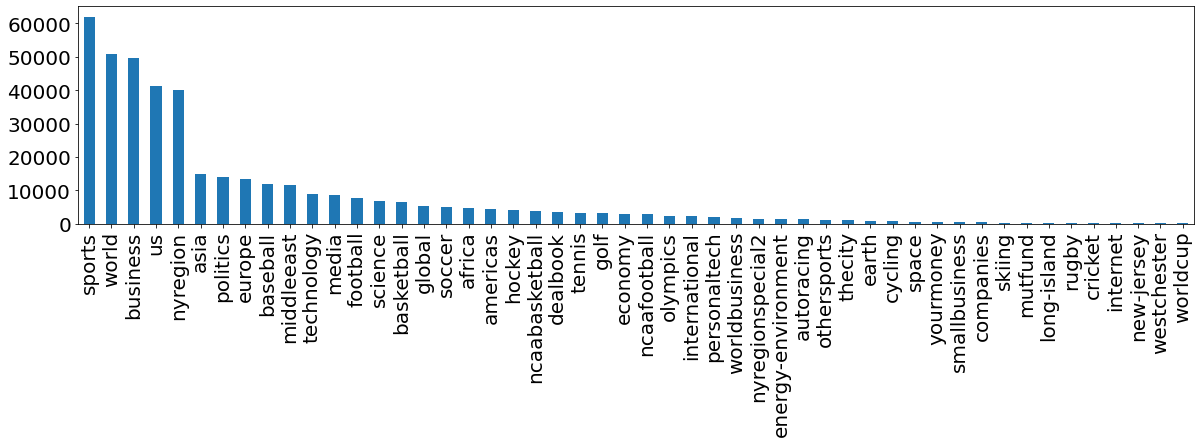

In [21]:
df['categories'].value_counts().nlargest(50).plot(kind='bar', 
                                                  figsize=(20, 4),
                                                  fontsize=20);

In [22]:
df = df.loc[df['categories'].isin(['sports', 'world', 'europe'])].copy()
df.shape

(126378, 6)

In [23]:
df['categories'] = df['categories'].str.replace('europe', 'world')
df['categories'].unique()

array(['sports', 'world'], dtype=object)

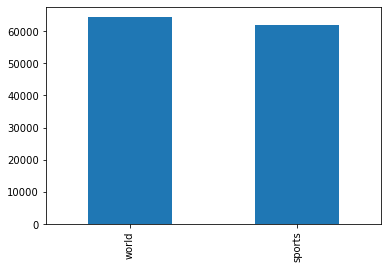

In [24]:
df['categories'].value_counts().plot(kind='bar');

In [25]:
df['title'].unique().shape, df[['title', 'abstract']].shape, df[['title', 'abstract']].drop_duplicates().shape 

((112424,), (126378, 2), (112831, 2))

In [26]:
df = df.drop_duplicates('title')

In [27]:
df = df[['categories', 'title', 'abstract']]
df.columns = ['class', 'title', 'text']

In [28]:
df.duplicated().sum()
df = df.reset_index(drop=True)

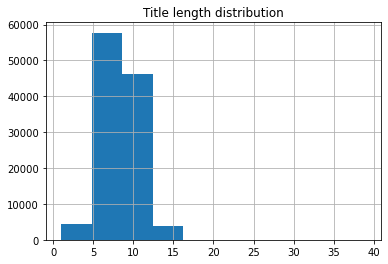

In [29]:
df['title'].str.split().str.len().hist()
plt.title('Title length distribution');

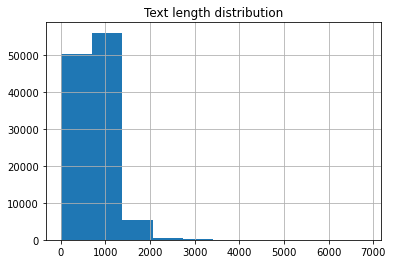

In [30]:
df['text'].str.split().str.len().hist()
plt.title('Text length distribution');

In [31]:
df['title'].values

array(['In Home Opener, Rangers Lose Gaborik and Drury to Injuries',
       'Timofey Mozgov of the Knicks Helps Russia at Worlds',
       'Chinese Activist, Missing for Weeks, Is Said to Be in Custody',
       ...,
       'With Harbaugh in His Corner, Alex Smith Emerges as 49ers’ Leader',
       '1972 Dolphins: Undefeated on Field, Undeterred Off It',
       'U.S. Enriches Companies Defying Its Policy on Iran'], dtype=object)

In [32]:
df = df[['class', 'title']].copy()
df['title'].duplicated().sum(), df['title'].isnull().sum()

(0, 0)

In [33]:
def get_edge_index(doc):
    edges = []
    for token in doc:
        if len(list(token.children)) > 0:
            kids = token.children
            edges.extend([(token.i, c.i) for c in kids])
    return torch.tensor(list(zip(*edges)))

def get_data_obj(text, label):
    doc = nlp(text)
    data = Data()
    data.x = torch.stack([torch.tensor(ft_model[t.text]) for t in doc])
    data.edge_index = get_edge_index(doc)
    data.label = 1 if label == 'sports' else 0 
    data.text = text
    data.tokens = list(doc)
    return data

In [34]:
%time
array = df[['title', 'class']].values
datalist = [get_data_obj(*row) for row in array]

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [35]:
len(datalist), datalist[:3]

(112424,
 [Data(edge_index=[2, 10], label=1, text="In Home Opener, Rangers Lose Gaborik and Drury to Injuries", tokens=[11], x=[11, 100]),
  Data(edge_index=[2, 8], label=1, text="Timofey Mozgov of the Knicks Helps Russia at Worlds", tokens=[9], x=[9, 100]),
  Data(edge_index=[2, 12], label=0, text="Chinese Activist, Missing for Weeks, Is Said to Be in Custody", tokens=[13], x=[13, 100])])

In [36]:
datalist[0].is_directed()

True

In [14]:
#torch.save(datalist, '../data/GraphClassificationData.pt')
datalist = torch.load('../data/GraphClassificationData.pt')

In [15]:
datalist[:3], type(datalist[0])

([Data(edge_index=[2, 6], label=0, text="U.N. Advises Congo Leaders on Vote Preparations", x=[7, 100]),
  Data(edge_index=[2, 6], label=0, text="Syrian Rebels Depart Homs District Under Deal", x=[7, 100]),
  Data(edge_index=[2, 12], label=1, text="Women in New York City Marathon Lead a Glorious Cross-City Sprint", x=[13, 100])],
 torch_geometric.data.data.Data)

In [16]:
for item in datalist:
    if len(item.text.split()) <= 4:
        datalist.remove(item)

In [17]:
datalist[:3], type(datalist[0])

([Data(edge_index=[2, 6], label=0, text="U.N. Advises Congo Leaders on Vote Preparations", x=[7, 100]),
  Data(edge_index=[2, 6], label=0, text="Syrian Rebels Depart Homs District Under Deal", x=[7, 100]),
  Data(edge_index=[2, 12], label=1, text="Women in New York City Marathon Lead a Glorious Cross-City Sprint", x=[13, 100])],
 torch_geometric.data.data.Data)

In [18]:
random.shuffle(datalist)

In [19]:
#torch.save(datalist, '../data/GraphClassificationData.pt')

In [20]:
train_size = int(len(datalist)*0.7)
print(train_size)
gcn_train = datalist[:train_size]
valid_size = int((len(datalist)-train_size)//2)
gcn_valid = datalist[train_size:(train_size+valid_size)]
gcn_test = datalist[(train_size+valid_size):]

75626


In [21]:
sum([i in gcn_valid for i in gcn_train]), sum([i in gcn_test for i in gcn_train])

(0, 0)

In [22]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, 
                 output_dim, dropout=0.25,
                 gcn_dropout=None,
                 nconvs=3, conv_layer=pyg_nn.GCNConv,
                 aggr='add', 
                 graph_aggr='mean',
                 flow='source_to_target',
                 weight=torch.tensor([1, 1])):
        
        super(GNNStack, self).__init__()
        self.conv = conv_layer
        self.dropout = dropout
        self.gcn_dropout = gcn_dropout
        self.num_layers = nconvs
        self.class_weight = weight
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim, 
                                                aggr, flow))
        self.lns = nn.ModuleList()
        #for i in range(nconvs):
        #    self.lns.append(nn.LayerNorm(hidden_dim))
        self.gmp = pyg_nn.global_mean_pool
        self.gmaxp = pyg_nn.global_max_pool

        for l in range(self.num_layers-1):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim, 
                                                    aggr, flow))
        
        linear_dim = hidden_dim*2
        self.post_mp = nn.Sequential(
            nn.Linear(linear_dim, linear_dim),
            nn.ReLU(),
            nn.Dropout(dropout), 
            nn.Linear(linear_dim, output_dim),
        )

    def build_conv_model(self, input_dim, hidden_dim, aggr, flow):
        return self.conv(input_dim, hidden_dim, aggr=aggr, flow=flow)

    def forward(self, data, batch_index, training=True):
        x, edge_index = data.x, data.edge_index

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index.long())
            emb = x
            x = F.relu(x)
            if self.gcn_dropout:
                x = F.dropout(x, p=self.gcn_dropout, training=training)
            #if not i == self.num_layers - 1:
            #    x = self.lns[i](x)
        
        x = torch.cat([self.gmp(x, batch_index),
                       self.gmaxp(x, batch_index)],
                      dim=1)
        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        #print('Got it')
        return F.nll_loss(pred, label, 
                          weight=self.class_weight)

In [23]:
'''Adding a function to get accuracy'''
def get_accuracy(preds, targets):
    
    preds = preds.argmax(dim=1)
    ncorrects = preds.eq(targets).sum().item()
    return ncorrects / len(targets)

In [24]:
#len(gcn_train), len(gcn_valid)

In [27]:
def train_graph_clf(train, 
                   valid, 
                   batch_size,
                   epochs,
                   hidden_dim,
                   conv_type,
                   aggr,
                   graph_aggr,
                   #writer,
                   flow='source_to_target',
                   heads=1,
                   dropout=0.25,
                   gcn_dropout=0.25,
                   optimiser=optim.Adam,
                   verbose=False,
                   lr=3e-5,
                   class_weight=torch.tensor([1., 1.])):
    
    train_ds = DataLoader(train, batch_size=batch_size)
    valid_ds = DataLoader(valid, batch_size=batch_size)
    
    dim = train[0].x.shape[1]
    model = GNNStack(dim, hidden_dim, 2, 
                     dropout=dropout,
                     gcn_dropout=gcn_dropout,
                     nconvs=heads,
                     conv_layer=conv_type,
                     aggr=aggr,
                     graph_aggr=graph_aggr,
                     flow=flow,
                     weight=class_weight,
                    )
    
    opt = optimiser(model.parameters(), lr=lr)
    train_losses = {i: [] for i in range(epochs)}
    train_accuracies = {i: [] for i in range(epochs)}
    valid_losses = {i: [] for i in range(epochs)}
    valid_accuracies = {i: [] for i in range(epochs)}
    
    #embeddings = []
    train_preds = []
    train_label = []
    for epoch in range(epochs):
        model.train()
        for batch in train_ds:
            opt.zero_grad()
            if batch.edge_index.dim() == 1: continue
            
            embedding, train_pred = model(batch, batch.batch, training=True)
        #writer.add_histogram('convs.0.weight', 
        #                     dict(model.named_parameters())['convs.0.weight'],
        #                    epoch)
        #writer.add_histogram('convs.1.weight', 
        #                     dict(model.named_parameters())['convs.1.weight'],
        #                    epoch)
        #writer.add_histogram('convs.2.weight', 
        #                     dict(model.named_parameters())['convs.2.weight'],
        #                    epoch)
        #if epoch != 0:
        #    writer.add_histogram('convs.2.weight Gradients', 
        #                         dict(model.named_parameters())['convs.2.weight'].grad,
        #                        epoch)
        #    writer.add_histogram('post_mp.2.weight Gradients', 
        #                         dict(model.named_parameters())['post_mp.2.weight'].grad,
        #                      epoch)
            train_label = batch.label
            train_loss = model.loss(train_pred, train_label)
            train_loss.backward()
            opt.step()
            train_acc = get_accuracy(train_pred, train_label)
            train_losses[epoch].append(train_loss.item())
            train_accuracies[epoch].append(train_acc)
        
        with torch.no_grad():
            model.eval()
            #import pdb;pdb.set_trace()
            for valid_batch in valid_ds:
                valid_label = valid_batch.label
                valid_embedding, valid_pred = model(valid_batch, 
                                                    valid_batch.batch,
                                                    training=False)
                valid_loss = model.loss(valid_pred, valid_label)
                valid_acc = get_accuracy(valid_pred, valid_label)
                valid_losses[epoch].append(valid_loss.item())
                valid_accuracies[epoch].append(valid_acc)
        
        if verbose:
            print('Epoch', epoch)
            print('Training Loss', sum(train_losses[epoch])/len(train_losses[epoch]))
            print('Training Accuracy', sum(train_accuracies[epoch])/len(train_accuracies[epoch]))
            print('Validation Loss', sum(valid_losses[epoch])/len(valid_losses[epoch]))
            print('Validation Accuracy', sum(valid_accuracies[epoch])/len(valid_accuracies[epoch]))
            print('#########################################################')
        


    return model, train_losses, train_accuracies, valid_losses, valid_accuracies

In [28]:
%pdb on

Automatic pdb calling has been turned ON


In [29]:
%%time 
epochs = 10
hidden_dim = 200
conv_type = pyg_nn.TransformerConv
aggr = 'add' # add, mean, max
graph_aggr = 'meanmax' # mean, max, sum, meanmax, minmax
flow = 'source_to_target'
heads = 1
dropout = 0.5
gcn_dropout = 0.5
optimiser = optim.Adam
verbose = True
lr = 2e-4
class_weight = torch.tensor([1., 1.])
batch_size = 32

gcn_net, gcn_train_losses, gcn_train_accs, gcn_valid_losses, gcn_valid_accs = train_graph_clf(
    #graph_data,
    gcn_train,
    gcn_valid,
    batch_size,
    epochs, 
    hidden_dim,
    conv_type=conv_type,
    aggr=aggr,
    graph_aggr=graph_aggr,
    flow=flow,
    heads=heads,
    dropout=dropout,
    optimiser=optimiser,
    lr=lr,
    verbose=verbose,
    class_weight=class_weight,
)

Epoch 0
Training Loss 0.26346503046865993
Training Accuracy 0.8896547165820644
Validation Loss 0.20009863270810369
Validation Accuracy 0.9205938292476754
#########################################################
Epoch 1
Training Loss 0.1868160495096455
Training Accuracy 0.9266021573604062
Validation Loss 0.16711472587648935
Validation Accuracy 0.9350169061707524
#########################################################
Epoch 2
Training Loss 0.15901935936578954
Training Accuracy 0.9395172377326566
Validation Loss 0.148564631284694
Validation Accuracy 0.9435844604113836
#########################################################
Epoch 3
Training Loss 0.13986159314152466
Training Accuracy 0.9468432741116751
Validation Loss 0.13853255793070182
Validation Accuracy 0.9467895886165117
#########################################################
Epoch 4
Training Loss 0.12661183243554383
Training Accuracy 0.9530298223350254
Validation Loss 0.13075500242301874
Validation Accuracy 0.9511041842772612
#

In [30]:
#torch.save(gcn_net.state_dict(), '../models/GCNGraphClassificationModel{}'.format(datetime.today()))

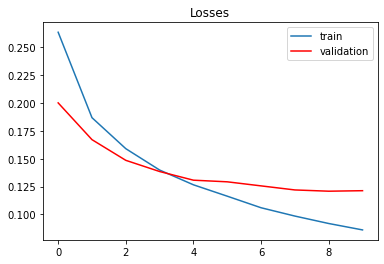

In [31]:
gcn_train_error = [sum(i)/len(i) for i in gcn_train_losses.values()]
gcn_valid_error = [sum(i)/len(i) for i in gcn_valid_losses.values()]
plt.plot(range(epochs), gcn_train_error)
plt.plot(range(epochs), gcn_valid_error, color='red')
plt.title('Losses')
plt.legend(['train', 'validation']);
#plt.savefig('../plots/StableGraphCLFLossesTransformerConv{}.png'.format(datetime.today()));

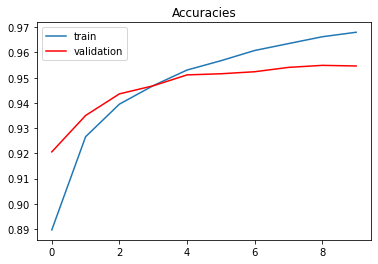

In [32]:
gcn_train_acc = [sum(i)/len(i) for i in gcn_train_accs.values()]
gcn_valid_acc = [sum(i)/len(i) for i in gcn_valid_accs.values()]
plt.plot(range(epochs), gcn_train_acc)
plt.plot(range(epochs), gcn_valid_acc, color='red')
plt.title('Accuracies')
plt.legend(['train', 'validation']);
#plt.savefig('../plots/StableGraphCLFAccsTransformerConv{}.png'.format(datetime.today()));

In [33]:
gcn_test_ds = list(DataLoader(gcn_test, batch_size=len(gcn_test)))[0]

embedding, gcn_test_pred = gcn_net(gcn_test_ds, gcn_test_ds.batch, training=False)
gcn_test_label = gcn_test_ds.label
gcn_test_loss = gcn_net.loss(gcn_test_pred, gcn_test_label)
gcn_test_acc = get_accuracy(gcn_test_pred, gcn_test_label)
print(gcn_test_loss)
print(gcn_test_acc)

tensor(0.1216, grad_fn=<NllLossBackward>)
0.9540910773787487


In [34]:
print(classification_report(gcn_test_label, gcn_test_pred.argmax(1)))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7637
           1       0.95      0.96      0.96      8569

    accuracy                           0.95     16206
   macro avg       0.95      0.95      0.95     16206
weighted avg       0.95      0.95      0.95     16206



#### Training a simple LSTM model to compare it with TransformerConv

In [35]:
def batchify_X(data):
    X = [d.x for d in data]
    max_size = len(max(X, key=len))
    dim = X[0].size(1)
    for i in range(len(X)):
        if len(X[i]) < max_size:
            X[i] = torch.cat([X[i], torch.tensor([[-100]*dim]*(max_size-len(X[i])))])
    return torch.stack(X)

def batchify_y(data):
    y = [torch.tensor(d.label) for d in data]
    return torch.stack(y)

# test
#a = train[:3]
#X = batchify_X(a)
#y = batchify_y(a)

In [36]:
%%time
rnn_train_ds = torch.utils.data.TensorDataset(batchify_X(gcn_train), batchify_y(gcn_train))
rnn_valid_ds = torch.utils.data.TensorDataset(batchify_X(gcn_valid), batchify_y(gcn_valid))

CPU times: user 11.4 s, sys: 508 ms, total: 11.9 s
Wall time: 11.9 s


In [37]:
class LSTMStack(nn.Module):
    def __init__(self, input_dim, 
                 hidden_dim, 
                 output_dim, 
                 dropout=0.25,
                 ):
        
        super(LSTMStack, self).__init__()
        #encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=1)
        #self.enc = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.enc = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout), 
            nn.Linear(hidden_dim, output_dim),
        )
        
        self.dropout = dropout

    def forward(self, data, training=True):

        x, hidden = self.enc(data)
        emb = x
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=training)
        
        x = torch.cat([x.mean(dim=1),
                       x.max(dim=1)[0]],
                      dim=1)
        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [38]:
def train_txt_clf(train, 
                   valid, 
                   batch_size,
                   epochs,
                   dim,
                   hidden_dim,
                   #writer,
                   dropout=0.25,
                   optimiser=optim.Adam,
                   verbose=True,
                   lr=2e-4
                 ):
    
    train_ds = DataLoader(train, batch_size=batch_size)
    valid_ds = DataLoader(valid, batch_size=batch_size)
    
    model = LSTMStack(
        dim, hidden_dim, 2, dropout=dropout,
    )
    
    opt = optimiser(model.parameters(), lr=lr)
    train_losses = {i: [] for i in range(epochs)}
    train_accuracies = {i: [] for i in range(epochs)}
    valid_losses = {i: [] for i in range(epochs)}
    valid_accuracies = {i: [] for i in range(epochs)}
    
    for epoch in range(epochs):
        model.train()
        for batch in train_ds:
            
            x, train_label = batch
            opt.zero_grad()
            #x = x.transpose(0, 1)
            embedding, train_pred = model(x, training=True)
        #writer.add_histogram('convs.0.weight', 
        #                     dict(model.named_parameters())['convs.0.weight'],
        #                    epoch)
        #writer.add_histogram('convs.1.weight', 
        #                     dict(model.named_parameters())['convs.1.weight'],
        #                    epoch)
        #writer.add_histogram('convs.2.weight', 
        #                     dict(model.named_parameters())['convs.2.weight'],
        #                    epoch)
        #if epoch != 0:
        #    writer.add_histogram('convs.2.weight Gradients', 
        #                         dict(model.named_parameters())['convs.2.weight'].grad,
        #                        epoch)
        #    writer.add_histogram('post_mp.2.weight Gradients', 
        #                         dict(model.named_parameters())['post_mp.2.weight'].grad,
        #                      epoch)
            train_loss = model.loss(train_pred, train_label)
            train_loss.backward()
            opt.step()
            train_acc = get_accuracy(train_pred, train_label)
            train_losses[epoch].append(train_loss.item())
            train_accuracies[epoch].append(train_acc)
        
        with torch.no_grad():
            model.eval()
            
            for valid_batch in valid_ds:
                valid_x, valid_label = valid_batch
                valid_embedding, valid_pred = model(valid_x, 
                                                    training=False)
                valid_loss = model.loss(valid_pred, valid_label)
                valid_acc = get_accuracy(valid_pred, valid_label)
                valid_losses[epoch].append(valid_loss.item())
                valid_accuracies[epoch].append(valid_acc)
        
        if verbose:
            print('Epoch', epoch)
            print('Training Loss', sum(train_losses[epoch])/len(train_losses[epoch]))
            print('Training Accuracy', sum(train_accuracies[epoch])/len(train_accuracies[epoch]))
            print('Validation Loss', sum(valid_losses[epoch])/len(valid_losses[epoch]))
            print('Validation Accuracy', sum(valid_accuracies[epoch])/len(valid_accuracies[epoch]))
            print('#########################################################')
        


    return model, train_losses, train_accuracies, valid_losses, valid_accuracies

In [39]:
%pdb on

Automatic pdb calling has been turned ON


In [39]:
%%time 
epochs = 10
hidden_dim = 200
dropout = 0.5
optimiser = optim.Adam
verbose = True
lr = 2e-4
batch_size = 32
dim = 100

lstm_net, rnn_train_losses, rnn_train_accs, rnn_valid_losses, rnn_valid_accs = train_txt_clf(
    train=rnn_train_ds, 
    valid=rnn_valid_ds, 
    batch_size=batch_size,
    epochs=epochs,
    dim=dim,
    hidden_dim=hidden_dim,
    #writer,
    dropout=dropout,
    optimiser=optimiser,
    verbose=verbose,
    lr=lr
)

Epoch 0
Training Loss 0.2921840446243179
Training Accuracy 0.8734322123519458
Validation Loss 0.2636160787040665
Validation Accuracy 0.9008699633699634
#########################################################
Epoch 1
Training Loss 0.21852946264886766
Training Accuracy 0.9124471235194586
Validation Loss 0.23338817287772834
Validation Accuracy 0.9083896872358411
#########################################################
Epoch 2
Training Loss 0.18811751593080825
Training Accuracy 0.9268956218274113
Validation Loss 0.20420716273831663
Validation Accuracy 0.9226278529163144
#########################################################
Epoch 3
Training Loss 0.1681800051966553
Training Accuracy 0.9350385998307953
Validation Loss 0.19014035210865723
Validation Accuracy 0.9281135531135531
#########################################################
Epoch 4
Training Loss 0.1545164713572219
Training Accuracy 0.940117385786802
Validation Loss 0.17892991400946526
Validation Accuracy 0.9313803183995492
###

In [40]:
torch.save(lstm_net.state_dict(), '../models/LSTMGraphClassificationModel{}'.format(datetime.today()))

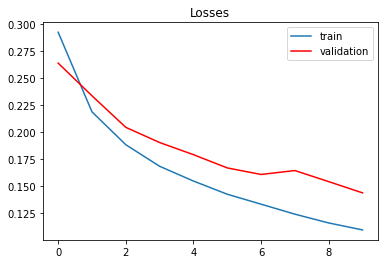

In [41]:
rnn_train_error = [sum(i)/len(i) for i in rnn_train_losses.values()]
rnn_valid_error = [sum(i)/len(i) for i in rnn_valid_losses.values()]
plt.plot(range(epochs), rnn_train_error)
plt.plot(range(epochs), rnn_valid_error, color='red')
plt.title('Losses')
plt.legend(['train', 'validation']);
#plt.savefig('../plots/StableGraphCLFLossesLSTMConv{}.png'.format(datetime.today()));

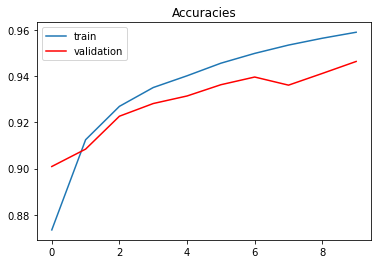

In [42]:
rnn_train_acc = [sum(i)/len(i) for i in rnn_train_accs.values()]
rnn_valid_acc = [sum(i)/len(i) for i in rnn_valid_accs.values()]
plt.plot(range(epochs), rnn_train_acc)
plt.plot(range(epochs), rnn_valid_acc, color='red')
plt.title('Accuracies')
plt.legend(['train', 'validation']);
#plt.savefig('../plots/StableGraphCLFAccsLSTMConv{}.png'.format(datetime.today()));

In [43]:
rnn_test_ds, rnn_test_label = batchify_X(gcn_test), batchify_y(gcn_test)
#test_ds, test_label = list(DataLoader(test_data, batch_size=len(test)))[0]

embedding, rnn_test_pred = lstm_net(rnn_test_ds, training=False)
rnn_test_loss = lstm_net.loss(rnn_test_pred, rnn_test_label)
rnn_test_acc = get_accuracy(rnn_test_pred, rnn_test_label)
print(rnn_test_loss)
print(rnn_test_acc)

tensor(0.1364, grad_fn=<NllLossBackward>)
0.9496482784154017


In [44]:
print(classification_report(rnn_test_label, rnn_test_pred.argmax(1)))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      7637
           1       0.93      0.97      0.95      8569

    accuracy                           0.95     16206
   macro avg       0.95      0.95      0.95     16206
weighted avg       0.95      0.95      0.95     16206



### Visualising GCN vs RNN Embeddings

In [ ]:
#gcn_net = GNNStack(100, 200, 2, 
#               dropout=0.5,
#               gcn_dropout=0.5,
#               nconvs=1,
#               conv_layer=pyg_nn.TransformerConv,
#               aggr='add',
#               graph_aggr='meanmax',
#               weight=torch.tensor([1., 1.]))
#gcn_net.load_state_dict(torch.load('../models/GCNGraphClassificationModel'))
#gcn_net.eval()

In [ ]:
#lstm_net = LSTMStack(100, 200, 2, 
#               dropout=0.5)
#lstm_net.load_state_dict(torch.load('../models/LSTMGraphClassificationModel'))
#lstm_net.eval()

In [17]:
#gcn_train = torch.load('../data/GraphClassificationData.pt')

In [45]:
gcn_data = random.sample(gcn_train, 10)
rnnX = batchify_X(gcn_data)#, batchify_y(gcn_data)

In [46]:
gcn_data[:3], rnnX.shape

([Data(edge_index=[2, 8], label=0, text="White House Sees North Korea Blustering, Not Acting", x=[9, 100]),
  Data(edge_index=[2, 7], label=0, text="Japan’s Opposition Senses Its Chance to Govern", x=[8, 100]),
  Data(edge_index=[2, 12], label=1, text="Swimmer Dana Vollmer Seeks Another Gold Medal, This Time as a Mother", x=[13, 100])],
 torch.Size([10, 15, 100]))

In [60]:
rnn_labels = []
for item in gcn_data:
    doc = list(nlp(item.text))
    tokens = [w.text for w in doc]
    rnn_labels.append(tokens)

In [61]:
rnn_labels[:3], len(rnn_labels)

([['White',
   'House',
   'Sees',
   'North',
   'Korea',
   'Blustering',
   ',',
   'Not',
   'Acting'],
  ['Japan', '’s', 'Opposition', 'Senses', 'Its', 'Chance', 'to', 'Govern'],
  ['Swimmer',
   'Dana',
   'Vollmer',
   'Seeks',
   'Another',
   'Gold',
   'Medal',
   ',',
   'This',
   'Time',
   'as',
   'a',
   'Mother']],
 10)

In [62]:
from torch.utils.tensorboard import SummaryWriter

In [63]:
gcn_writer = SummaryWriter(log_dir='RNNvsGCN/GCNEmbeddings/'.format(datetime.today()))

In [64]:
rnn_writer = SummaryWriter(log_dir='RNNvsGCN/RNNEmbeddings/'.format(datetime.today()))

In [74]:
def visualise_gcn(gcn_data):
    i = 0
    for obj in gcn_data:
        
        data = list(DataLoader([obj], batch_size=1))[0]
        tokens = list(nlp(data.text[0]))
        metadata = [i.text for i in tokens]
        assert len(metadata) == len(data.x)
        gcn_writer.add_embedding(mat=data.x, metadata=metadata, 
                                 global_step=int(str(i)+'1'),
                                 tag=' '.join(metadata))
        embedding, pred = gcn_net(data, data.batch, training=False)
        assert len(metadata) == len(embedding)
        gcn_writer.add_embedding(mat=embedding, metadata=metadata, 
                                 global_step=int(str(i)+'2'),
                                 tag=' '.join(metadata))
        i += 1
        
def visualise_rnn(rnn_data, word_labels):
    i = 0
    for obj, words in zip(rnn_data, word_labels):
        
        obj = obj[:len(words)]
        rnn_writer.add_embedding(mat=obj, metadata=words, 
                                 global_step=int(str(i)+'1'),
                                 tag=' '.join(words))
        embedding, rnn_test_pred = lstm_net(obj.unsqueeze(0), training=False)
        rnn_writer.add_embedding(mat=embedding[:len(words)].squeeze(0), metadata=words, 
                                 global_step=int(str(i)+'2'),
                                 tag=' '.join(words))
        i += 1


def gcn_return_tsne(data):
    
    title = data.text[0]
    tokens = list(nlp(title))
    labels = [i.text for i in tokens]
    fig, ax = plt.subplots(2, 1)
    ftX = TSNE(n_components=2).fit_transform(data.x)
    x = ftX[:, 0]
    y = ftX[:, 1]
    ax[0].scatter(x, y)
    assert len(ftX) == len(labels)
    for i, txt in enumerate(labels):
        ax[0].annotate(txt, (x[i], y[i]))
    ax[0].set_title(title)
    
    embedding, pred = gcn_net(data, data.batch, training=False)
    embX = TSNE(n_components=2).fit_transform(embedding.detach().numpy())
    ex = embX[:, 0]
    ey = embX[:, 1]
    ax[1].scatter(ex, ey)
    assert len(embX) == len(labels)
    
    for i, txt in enumerate(labels):
        ax[1].annotate(txt, (ex[i], ey[i]))
    #ax[1].set_title(' '.join(metadata))

In [65]:
visualise_gcn(gcn_data)

In [75]:
visualise_rnn(rnnX, rnn_labels)

In [47]:
gcndata = DataLoader(gcn_data, batch_size=1)
labels = []
for batch in gcndata:
    tokens = list(nlp(batch.text[0]))
    metadata = [i.text for i in tokens]
    labels.append(metadata)
len(labels), labels[:2]

(10,
 [['White',
   'House',
   'Sees',
   'North',
   'Korea',
   'Blustering',
   ',',
   'Not',
   'Acting'],
  ['Japan', '’s', 'Opposition', 'Senses', 'Its', 'Chance', 'to', 'Govern']])

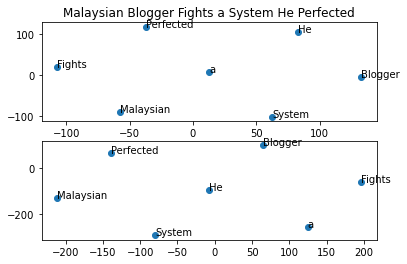

In [59]:
gcn_return_tsne(list(gcndata)[3])

In [76]:
a = "Obama’s Support of Erdogan Is a Stark Reminder of Turkey’s Value to U.S."
doc = nlp(a)

In [77]:
for token in doc:
    print(token)
    print([c.text for c in token.children])
    print('###########################################')

Obama
['’s']
###########################################
’s
[]
###########################################
Support
['Obama', 'of']
###########################################
of
['Erdogan']
###########################################
Erdogan
[]
###########################################
Is
['Support', 'Reminder', 'to']
###########################################
a
[]
###########################################
Stark
[]
###########################################
Reminder
['a', 'Stark', 'of']
###########################################
of
['Value']
###########################################
Turkey
['’s']
###########################################
’s
[]
###########################################
Value
['Turkey']
###########################################
to
['U.S.']
###########################################
U.S.
[]
###########################################
